# The working notebook for my zillow regression project

### Imports Required

In [36]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import TweedieRegressor

from env import host, user, password
import wrangle

import warnings
warnings.filterwarnings("ignore")

## Wrangle

The first thing I need to do is acquire the data fom the SQL database. The functions to do this are stored in wrangle.py on my github. 

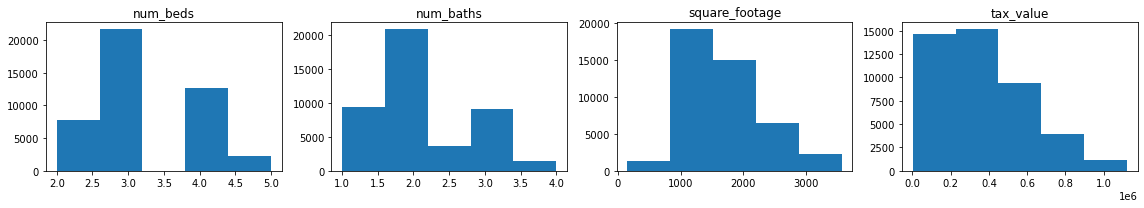

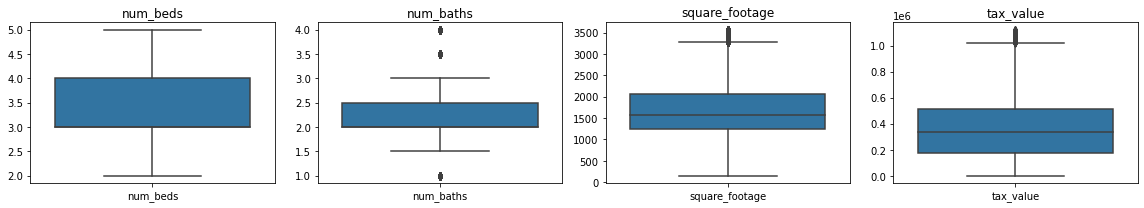

In [2]:
# comment out viz before putting in report
train, validate, test = wrangle.wrangle_zillow()

In [3]:
train.shape, validate.shape, test.shape

((24858, 6), (10654, 6), (8879, 6))

In [4]:
train.head()

num_beds  num_baths  square_footage  tax_value year_built county_code
29516       4.0        2.5          1470.0   311578.0     1978.0      6059.0
41702       4.0        2.0          1208.0   306475.0     1956.0      6059.0
4232        3.0        3.0          2063.0   124214.0     1956.0      6037.0
12495       2.0        1.0          1984.0    71410.0     1913.0      6037.0
38584       3.0        2.0          1430.0   203928.0     1950.0      6037.0

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24858 entries, 29516 to 36552
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_beds        24858 non-null  float64
 1   num_baths       24858 non-null  float64
 2   square_footage  24858 non-null  float64
 3   tax_value       24858 non-null  float64
 4   year_built      24858 non-null  object 
 5   county_code     24858 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.3+ MB


Split into X and y variables

In [6]:
# Run split_tvt_into_variables / the target is tax_value
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_tvt_into_variables(train, validate, test, target='tax_value')

In [7]:
train.head()

num_beds  num_baths  square_footage  tax_value year_built county_code
29516       4.0        2.5          1470.0   311578.0     1978.0      6059.0
41702       4.0        2.0          1208.0   306475.0     1956.0      6059.0
4232        3.0        3.0          2063.0   124214.0     1956.0      6037.0
12495       2.0        1.0          1984.0    71410.0     1913.0      6037.0
38584       3.0        2.0          1430.0   203928.0     1950.0      6037.0

In [8]:
X_train.head()

num_beds  num_baths  square_footage
29516       4.0        2.5          1470.0
41702       4.0        2.0          1208.0
4232        3.0        3.0          2063.0
12495       2.0        1.0          1984.0
38584       3.0        2.0          1430.0

In [9]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Min_Max_Scaler(X_train, X_validate, X_test)

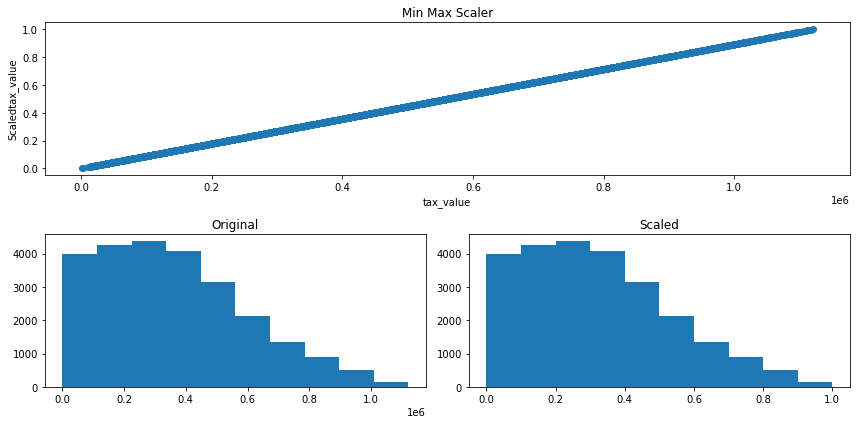

In [10]:
wrangle.visualize_scaled_date(sklearn.preprocessing.MinMaxScaler(), 'Min Max Scaler', 'tax_value')


In [11]:
X_train.head()

num_beds  num_baths  square_footage
29516       4.0        2.5          1470.0
41702       4.0        2.0          1208.0
4232        3.0        3.0          2063.0
12495       2.0        1.0          1984.0
38584       3.0        2.0          1430.0

In [12]:
X_train_scaled.head()

num_beds  num_baths  square_footage
29516  0.666667   0.500000        0.352760
41702  0.666667   0.333333        0.271970
4232   0.333333   0.666667        0.535615
12495  0.000000   0.000000        0.511255
38584  0.333333   0.333333        0.340426

## Exploration

In [13]:
# Correlation Matrix
corr_df = pd.concat([X_train_scaled, y_train], axis=1)
corrs = corr_df.corr()
corrs

num_beds  num_baths  square_footage  tax_value
num_beds        1.000000   0.579184        0.607678   0.194477
num_baths       0.579184   1.000000        0.774739   0.359318
square_footage  0.607678   0.774739        1.000000   0.431936
tax_value       0.194477   0.359318        0.431936   1.000000

In [14]:
def plot_variable_pairs(df):
    '''
    Takes in a dataframe and plots all pairwise relationships.
    '''
    sns.pairplot(df)

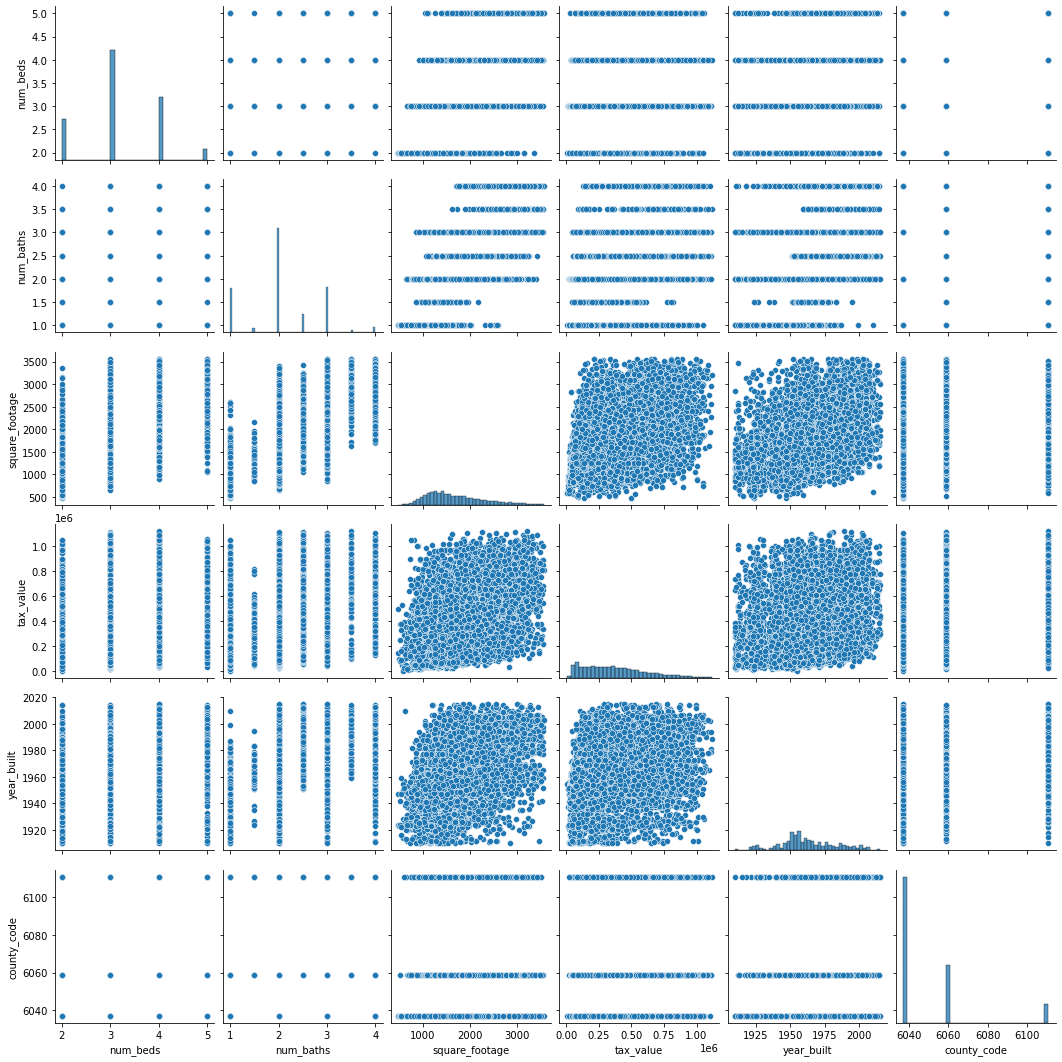

In [15]:
plot_variable_pairs(train.sample(10_000))

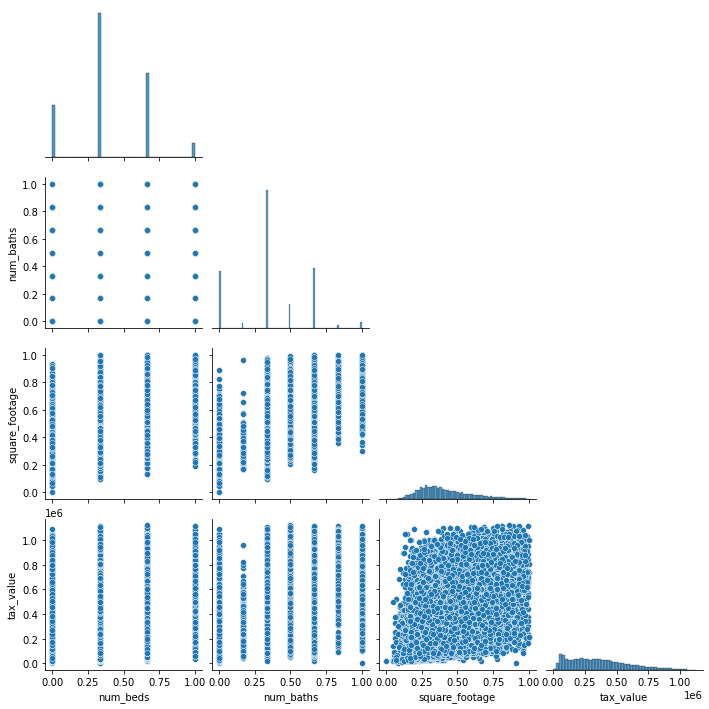

In [16]:
sns.pairplot(corr_df[['num_beds', 'num_baths', 'square_footage', 'tax_value']], corner=True)
plt.show()

In [17]:
corr_spearman = corr_df.corr(method='spearman')
corr_spearman

num_beds  num_baths  square_footage  tax_value
num_beds        1.000000   0.575273        0.619687   0.192883
num_baths       0.575273   1.000000        0.794695   0.357623
square_footage  0.619687   0.794695        1.000000   0.395469
tax_value       0.192883   0.357623        0.395469   1.000000

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24858 entries, 29516 to 36552
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_beds        24858 non-null  float64
 1   num_baths       24858 non-null  float64
 2   square_footage  24858 non-null  float64
 3   tax_value       24858 non-null  float64
 4   year_built      24858 non-null  object 
 5   county_code     24858 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.3+ MB


In [19]:
train.shape

(24858, 6)

In [20]:
r, p = stats.pearsonr(X_train_scaled['num_beds'], y_train)
print(f'The p-value is: {p}. There is {round(p,2)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 2.0785015490055953e-210. There is 0.0% chance that we see these results by chance.
r = 0.19


number of bedrooms and tax value are somewhat correlated

In [21]:
r, p = stats.pearsonr(X_train_scaled['num_baths'], y_train)
print(f'The p-value is: {p}. There is {round(p,2)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.36


number of bathrooms and tax value are somewhat correlated

In [22]:
r, p = stats.pearsonr(X_train['square_footage'], y_train)
print(f'The p-value is: {p}. There is {round(p,5)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.43


the amount of square footage and the tax value are strongly coorelated

In [23]:
#sns.swarmplot(x=X_train_scaled['num_beds'], y=y_train, data=train)
#plt.show()

In [24]:
def plot_categorical_and_continuous_vars(df, continuous, categorical):
    '''
    Takes in a dataframe, a list of continuous variables and a list of categorical 
    variables of the dataframe as arguments. Creates three different plots of each
    categorical pair.
    '''
    for con in continuous:
        for cat in categorical:
            plt.figure(figsize = (20,10))
            plt.subplot(1,3,1)
            sns.swarmplot(x=df[cat], y=df[con], data=df)
            plt.subplot(1,3,2)
            sns.stripplot(x=df[cat], y=df[con], data=df)
            plt.subplot(1,3,3)
            sns.boxplot(x=df[cat], y=df[con], data=df)

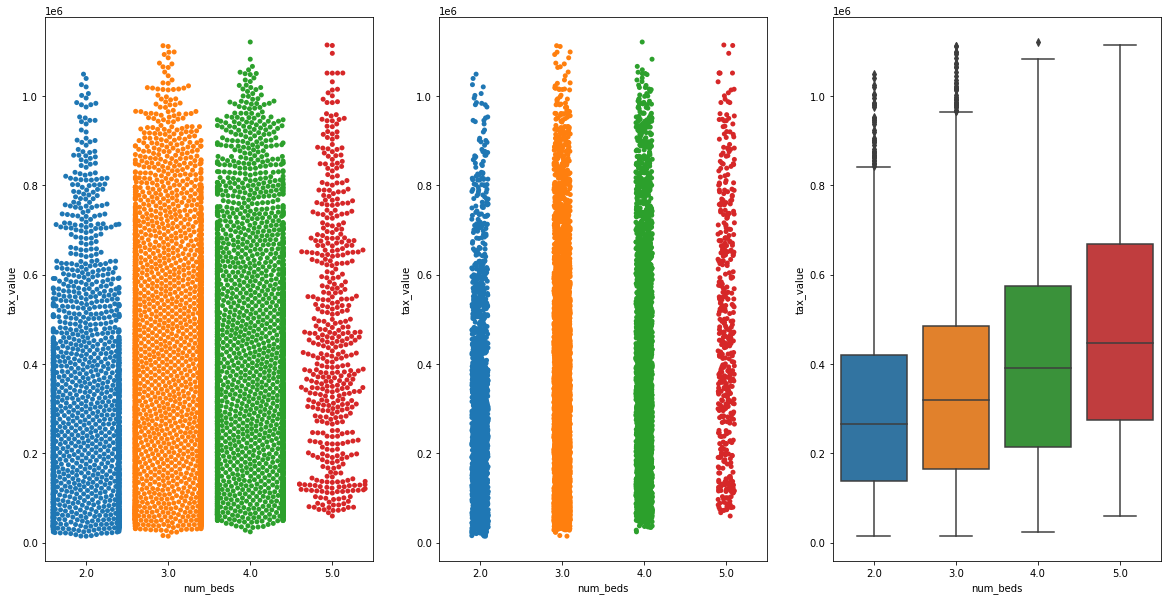

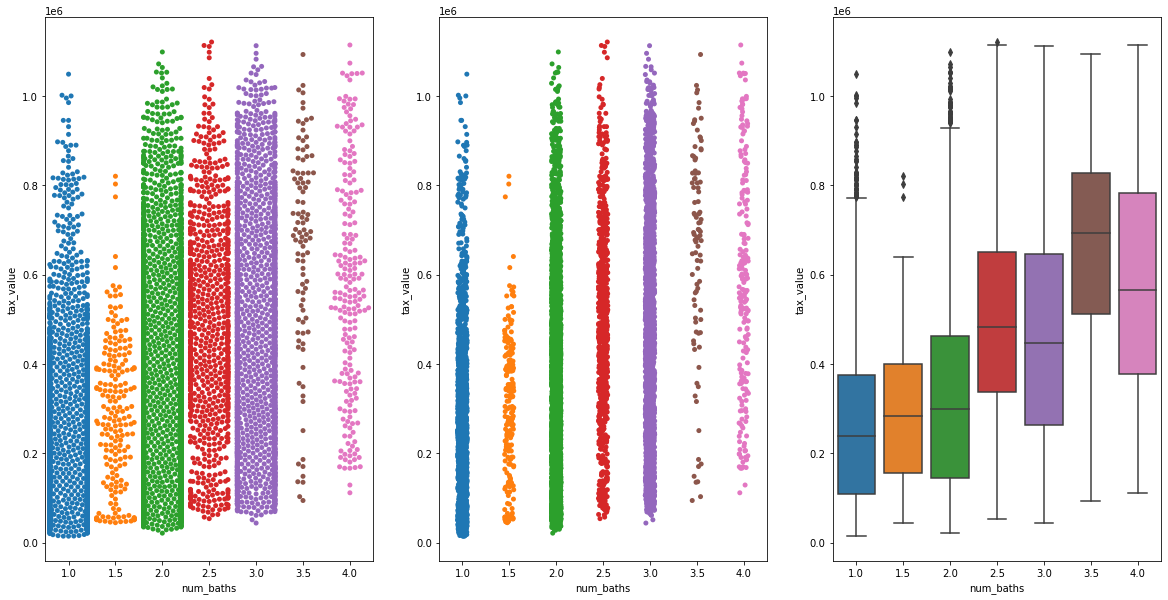

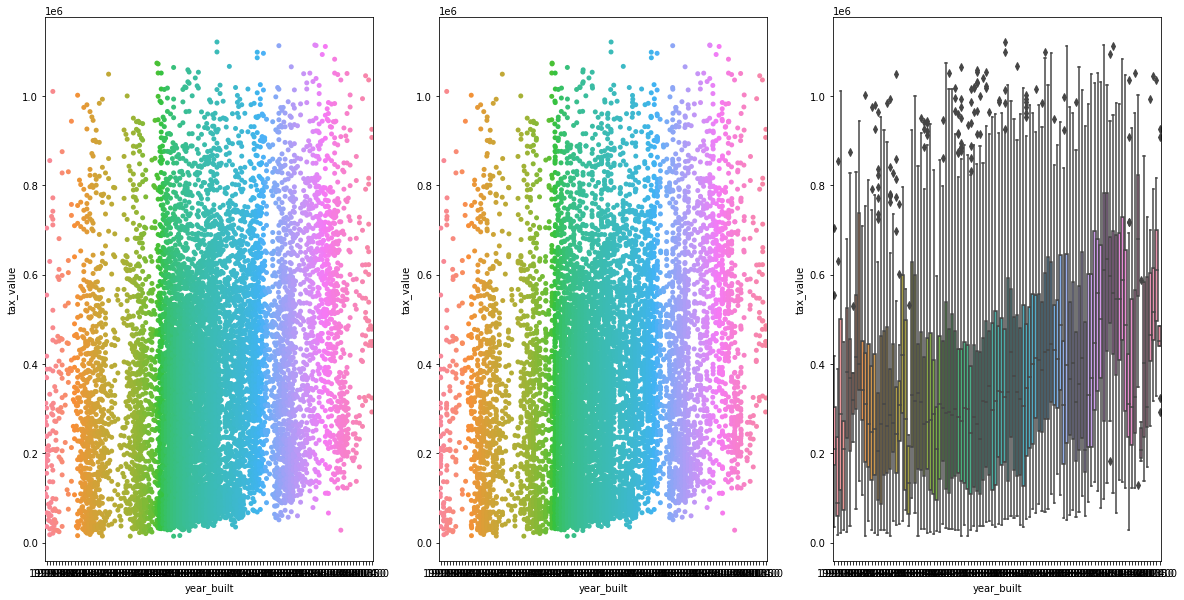

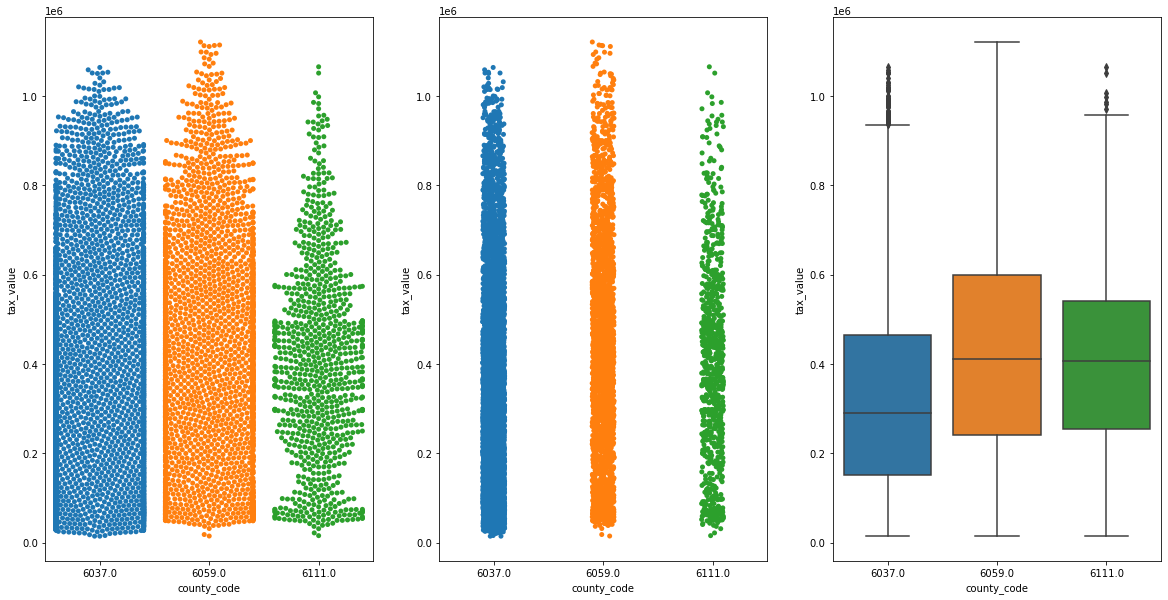

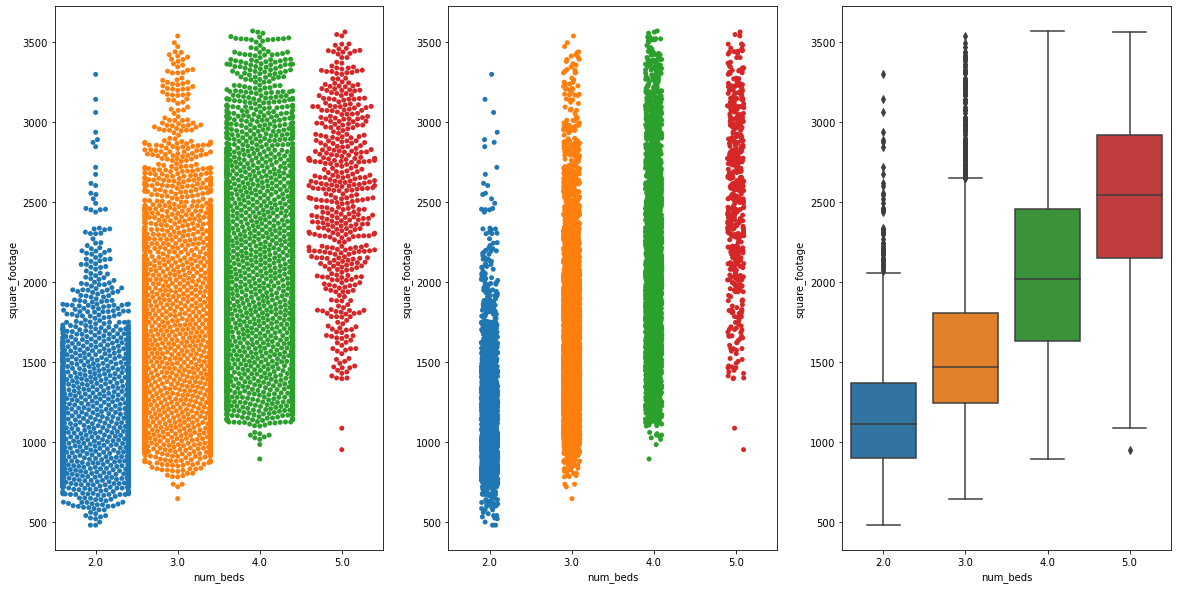

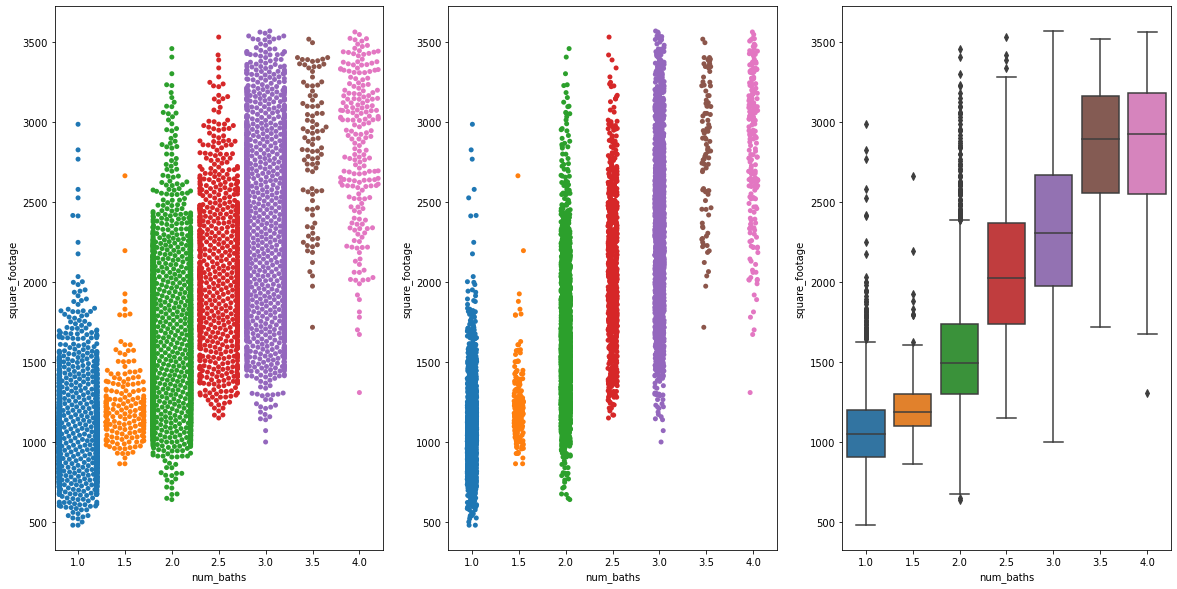

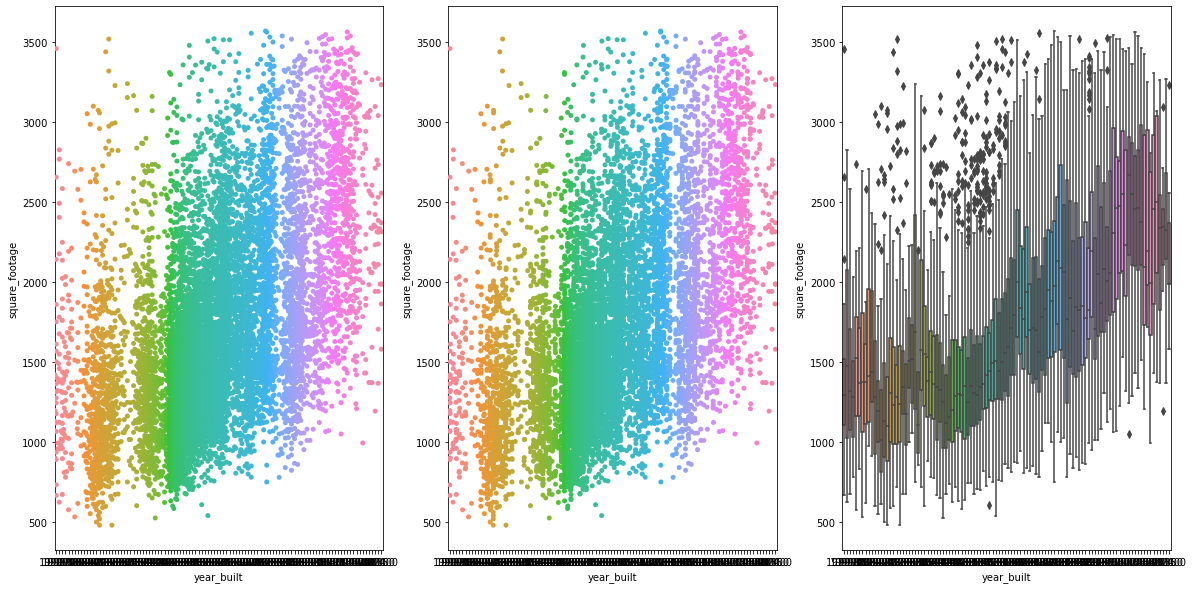

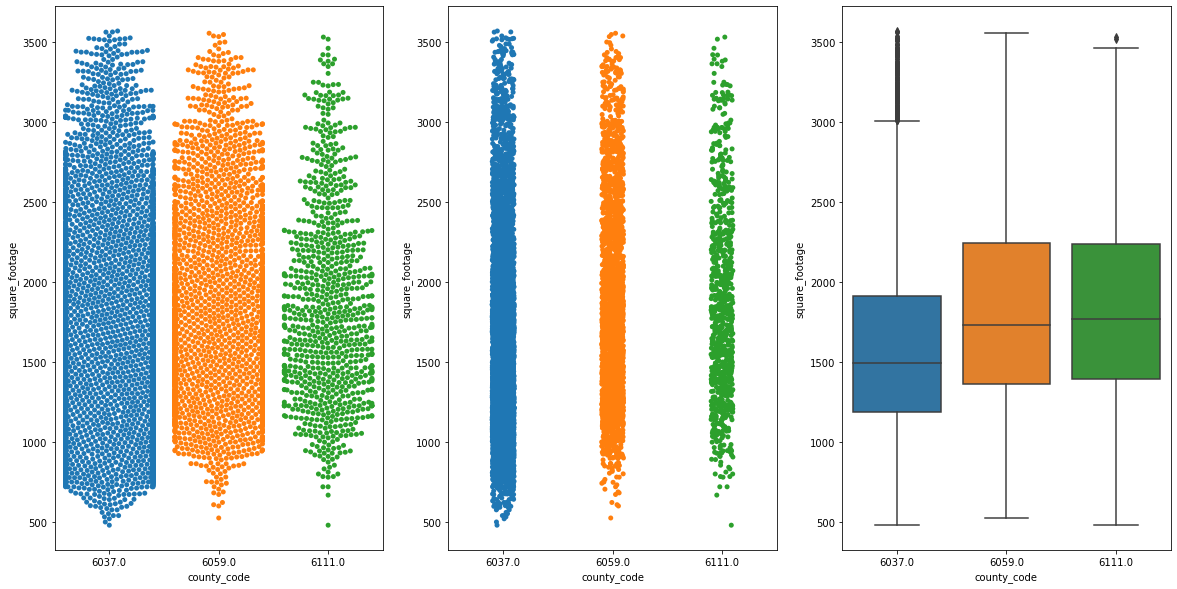

In [25]:
zillow_con = ['tax_value','square_footage']
zillow_cat= ['num_beds','num_baths','year_built','county_code']

plot_categorical_and_continuous_vars(train.sample(10_000), zillow_con, zillow_cat)

In [26]:
# 6037	Los Angeles	CA
# 6059	Orange	CA
# 6111	Ventura	CA


In [27]:
def plot_categorical_and_continuous_vars(categorical_var, continuous_var, df):
    """
    This function that takes in a string name of a categorical variable, 
    a string name from a continuous variable and the df they live in and
    displays 4 different plots.
    """
    plt.suptitle(f'{continuous_var} by {categorical_var}', fontsize=18)
    
    #sns.lineplot(x=categorical_var, y=continuous_var, data=df)
    #plt.xlabel(categorical_var, fontsize=12)
    #plt.ylabel(continuous_var, fontsize=12)
    
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind='box', palette='Greens')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="swarm", palette='Blues')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="bar", palette='Purples')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)

<Figure size 432x288 with 0 Axes>

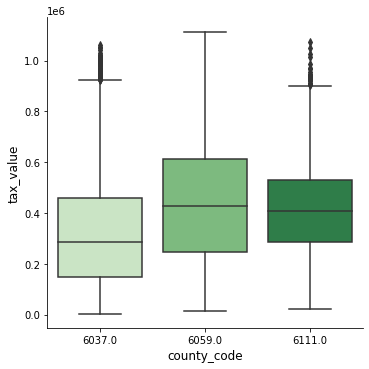

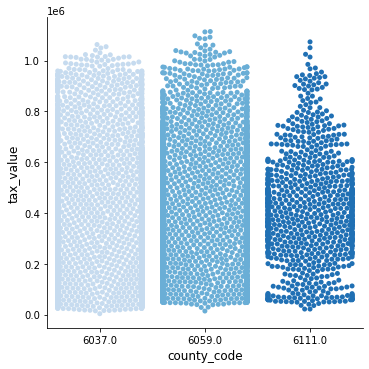

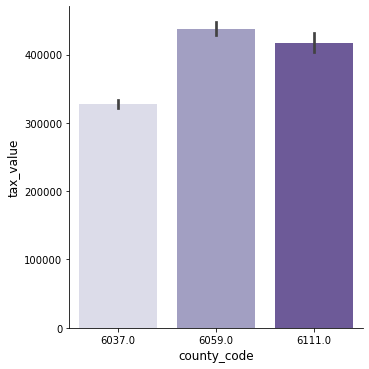

In [28]:
plot_categorical_and_continuous_vars('county_code', 'tax_value', train.sample(10_000))

In [29]:
def square_footage_rounded(df):
    """
    Takes in a df and returns the df with new feature "round_square_footage"
    """
    df["round_square_footage"] = round(train.square_footage // 1000)
    return df

In [30]:
new_train = square_footage_rounded(train)
new_train.head()

num_beds  num_baths  square_footage  tax_value year_built county_code  \
29516       4.0        2.5          1470.0   311578.0     1978.0      6059.0   
41702       4.0        2.0          1208.0   306475.0     1956.0      6059.0   
4232        3.0        3.0          2063.0   124214.0     1956.0      6037.0   
12495       2.0        1.0          1984.0    71410.0     1913.0      6037.0   
38584       3.0        2.0          1430.0   203928.0     1950.0      6037.0   

       round_square_footage  
29516                   1.0  
41702                   1.0  
4232                    2.0  
12495                   1.0  
38584                   1.0

In [31]:
new_train['round_square_footage'] = new_train.round_square_footage.astype('object')

In [32]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24858 entries, 29516 to 36552
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_beds              24858 non-null  float64
 1   num_baths             24858 non-null  float64
 2   square_footage        24858 non-null  float64
 3   tax_value             24858 non-null  float64
 4   year_built            24858 non-null  object 
 5   county_code           24858 non-null  object 
 6   round_square_footage  24858 non-null  object 
dtypes: float64(4), object(3)
memory usage: 1.5+ MB


<Figure size 432x288 with 0 Axes>

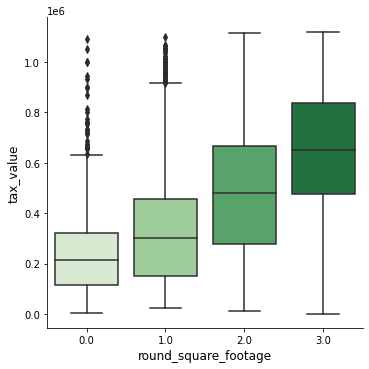

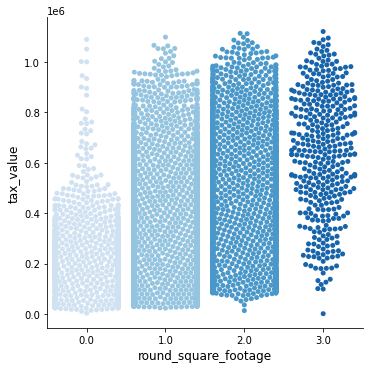

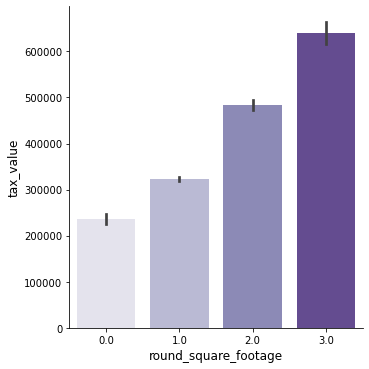

In [33]:
plot_categorical_and_continuous_vars('round_square_footage', 'tax_value', new_train.sample(10_000))

## Model

In [37]:
X_train.shape, X_validate.shape, X_test.shape

((24858, 3), (10654, 3), (8879, 3))

In [38]:
X_train.head()

num_beds  num_baths  square_footage
29516       4.0        2.5          1470.0
41702       4.0        2.0          1208.0
4232        3.0        3.0          2063.0
12495       2.0        1.0          1984.0
38584       3.0        2.0          1430.0

In [39]:
y_train.head()

29516    311578.0
41702    306475.0
4232     124214.0
12495     71410.0
38584    203928.0
Name: tax_value, dtype: float64

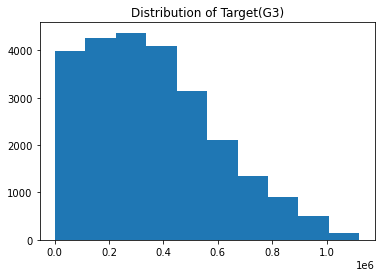

In [40]:
plt.hist(y_train)
plt.title('Distribution of Target(G3)')
plt.show()

### Baseline

In [42]:
# can't add new predicted column to Y until we turn it into a dataframe 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [44]:
# 1. Predict mean
value_pred_mean = y_train.tax_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

In [45]:
# 2. Predict median
value_pred_median = y_train.tax_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

In [47]:
y_train.head()

tax_value  value_pred_mean  value_pred_median
29516   311578.0    364652.814547           331779.0
41702   306475.0    364652.814547           331779.0
4232    124214.0    364652.814547           331779.0
12495    71410.0    364652.814547           331779.0
38584   203928.0    364652.814547           331779.0

In [50]:
# 3. RMSE of predicted mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean) ** (0.5)

In [51]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  233853.05 
Validate/Out-of-Sample:  233903.73


In [53]:
# 4. RMSE of predicted median
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median) ** (0.5)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  236152.36 
Validate/Out-of-Sample:  236027.7


Mean has the lower value so I will use that as the baseline.

In [55]:
# building a df of our metrics for model selsection 
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [56]:
metric_df

model     RMSE_train  RMSE_validate
0  mean_baseline  236152.362296  236027.699082

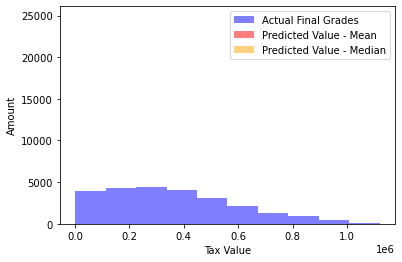

In [65]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.value_pred_mean, bins=1, color='red', alpha=.5,  label="Predicted Value - Mean")
plt.hist(y_train.value_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Amount")
plt.legend()
plt.show()

### LinearRegression (OLS)

In [68]:
# create model
lm = LinearRegression()

In [69]:
# fit model
lm.fit(X_train, y_train.tax_value)

LinearRegression()

In [70]:
#predict train
y_train['value_pred_lm'] = lm.predict(X_train)

In [71]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm) ** (1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  209508.01029809145 
Validation/Out-of-Sample:  208907.12959332482


In [74]:
# add result to metric df
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [75]:
metric_df

model     RMSE_train  RMSE_validate
0  mean_baseline  236152.362296  236027.699082
1  OLS Regressor  209508.010298  208907.129593
2  OLS Regressor  209508.010298  208907.129593

### LassoLars

In [76]:
# create
lars = LassoLars(alpha=0.01)

# fit
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lars) ** (1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  209508.0103322495 
Validation/Out-of-Sample:  208907.10711890485 
Difference:  -600.9032133446599


In [77]:
metric_df = metric_df.append({
    'model': 'lasso_alpha0.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [78]:
metric_df

model     RMSE_train  RMSE_validate
0    mean_baseline  236152.362296  236027.699082
1    OLS Regressor  209508.010298  208907.129593
2    OLS Regressor  209508.010298  208907.129593
3  lasso_alpha0.01  209508.010332  208907.107119

### TweedieRegressor (GLM)

<AxesSubplot:>

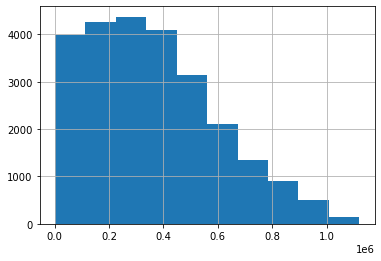

In [79]:
y_train.tax_value.hist()

In [80]:
y_train.max()

tax_value            1.120474e+06
value_pred_mean      3.646528e+05
value_pred_median    3.317790e+05
value_pred_lm        7.437924e+05
value_pred_lars      7.437777e+05
dtype: float64

In [81]:
# create
glm = TweedieRegressor(power=1, alpha=0)

# fit
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm) ** (1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  233853.0532940102 
Validation/Out-of-Sample:  233903.72763096401


In [82]:
 metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [83]:
metric_df

model     RMSE_train  RMSE_validate
0    mean_baseline  236152.362296  236027.699082
1    OLS Regressor  209508.010298  208907.129593
2    OLS Regressor  209508.010298  208907.129593
3  lasso_alpha0.01  209508.010332  208907.107119
4      glm_poisson  233853.053294  233903.727631

### Polynomial Regression

Create the new features, based on value indicated for degree for train, validate & test.

Fit the Linear Regression model

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?



In [84]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

### LinearRegression

In [87]:
# create
lm2 = LinearRegression()

# fit
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2) ** (1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  209401.6604252682 
Validation/Out-of-Sample:  208925.81983444525


In [88]:
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [89]:
metric_df

model     RMSE_train  RMSE_validate
0    mean_baseline  236152.362296  236027.699082
1    OLS Regressor  209508.010298  208907.129593
2    OLS Regressor  209508.010298  208907.129593
3  lasso_alpha0.01  209508.010332  208907.107119
4      glm_poisson  233853.053294  233903.727631
5        quadratic  209401.660425  208925.819834

### Evaluate

Plotting Actual vs. Predicted Values

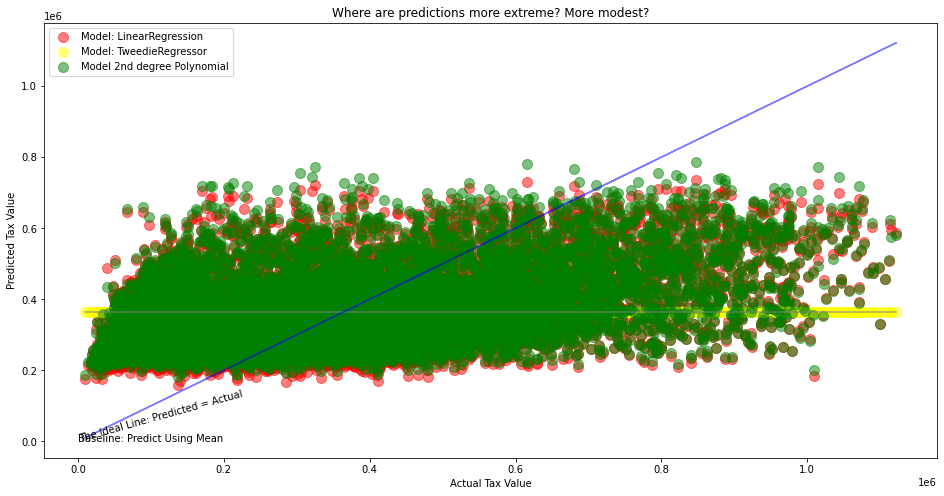

In [92]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

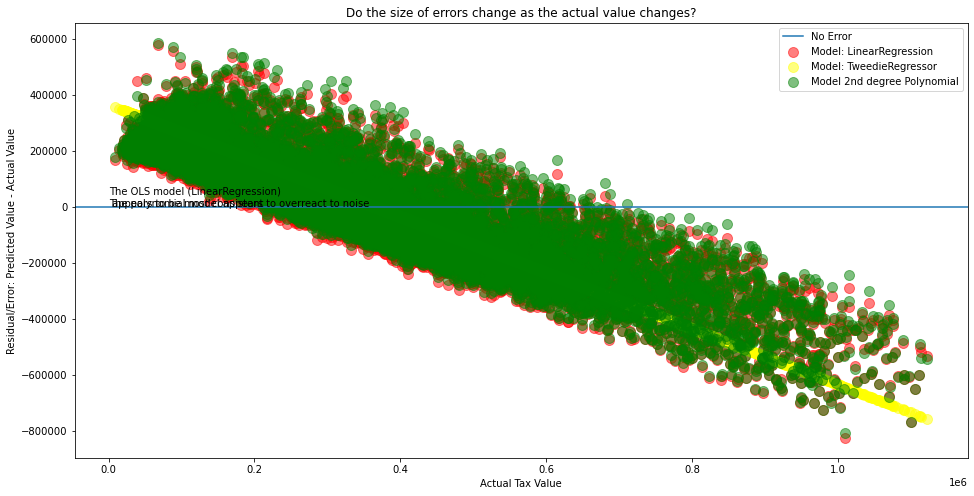

In [94]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Value - Actual Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

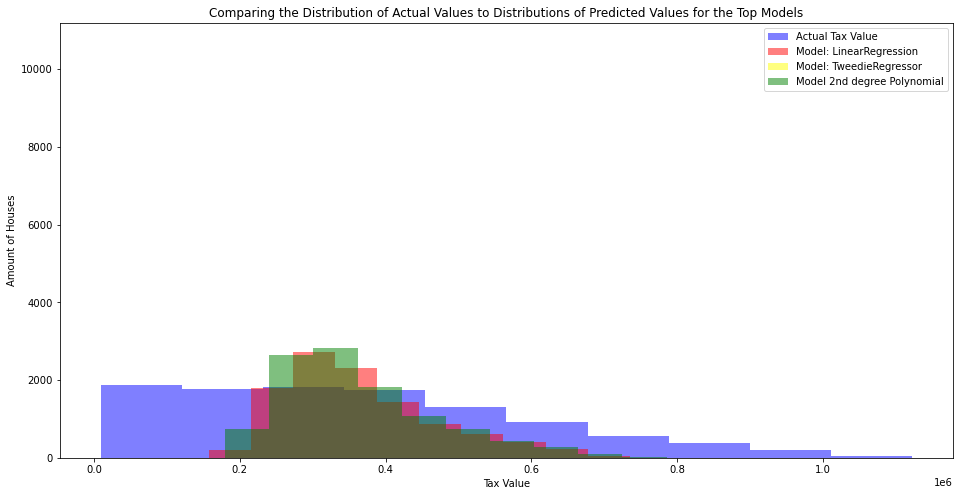

In [95]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Amount of Houses")
plt.title("Comparing the Distribution of Actual Values to Distributions of Predicted Values for the Top Models")
plt.legend()
plt.show()